# Introduction

This notebook will explore the thought process of features that can be used to ameliorate the gait feature pipeline. In ingesting signals from gait data (walking motion) there are a lot of variability that could occur, such as how a test subject can stop doing their test in the middle of test, doing a turn or rotation, which might cause biases towards the feature computation. Therefore this notebook will explore how we can segment the walking signal data into 3 separate sequence as <b> resting, walking, and rotation </b>.

In [1]:
import sys
import warnings
sys.path.append("../src/pipeline")
from utils import query_utils as query
from utils import gait_features_utils as gproc
import synapseclient as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set_style("dark")
warnings.simplefilter("ignore")

In [2]:
## log in to synapse for querying data in SageBionetworks ## 
syn = sc.login()

Welcome, aryton tediarjo!



INFO:synapseclient_default:Welcome, aryton tediarjo!



In [3]:
path_data = query.get_walking_synapse_table(syn, 
                                            "syn12514611", 
                                            "MPOWER_V2", 
                                            healthCodes = ["1fa674e9-2c49-4260-83f0-681ace2a5125", # parkinson
                                                          "c52432c0-754b-4490-b131-9684da102f6c", # control 
                                                          "e8167893-1b3a-4c71-94f4-5b3cb9b52165", # control
                                                          "f80e44ed-ce6f-4aff-8a6a-cfa74c823f6a"]) # parkinson

Querying MPOWER_V2 Data


INFO:synapseclient_default:Downloading 0 files, 264 cached locally


In [4]:
## package call ##
gaitFeaturize = gproc.GaitFeaturize()
filepath = path_data["walk_motion.json_pathfile"].iloc[2]
accel_data = query.get_sensor_data_from_filepath(filepath, "userAcceleration")
rotation_data = query.get_sensor_data_from_filepath(filepath, "rotationRate")

# 1. Segmenting Rotation Motion

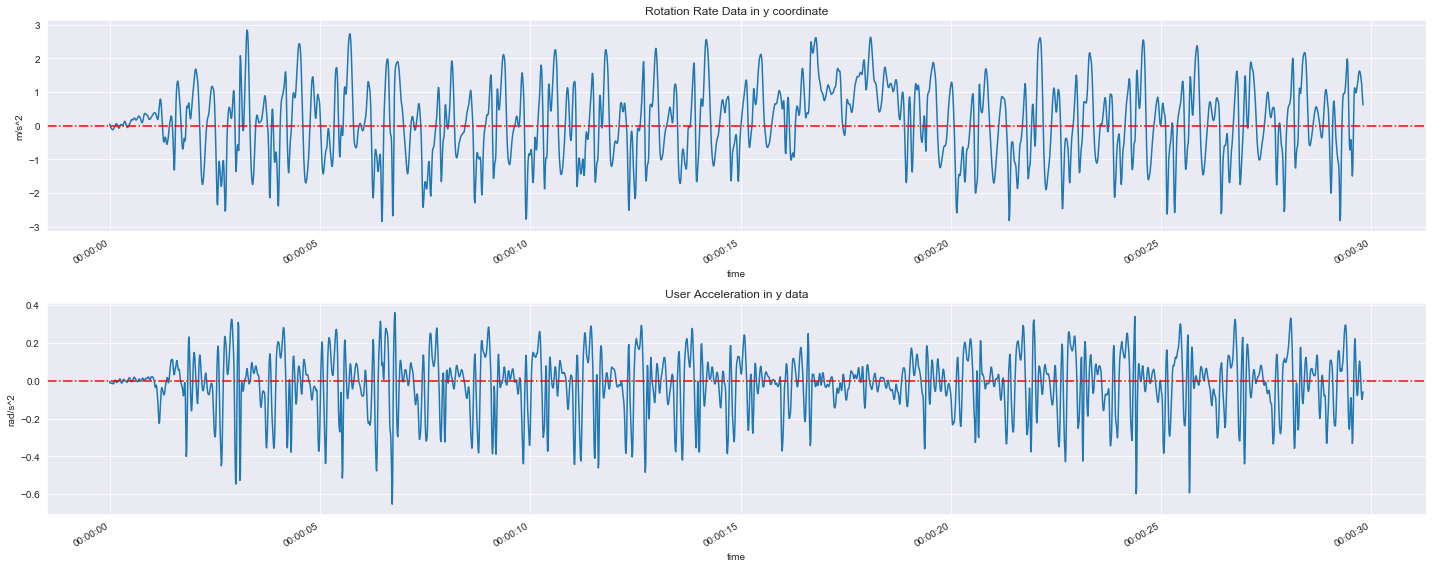

In [5]:
fig, axes = plt.subplots(2, 1)


rotation_data["y"].plot(grid = True, ax = axes[0], figsize = (20,8))
axes[0].set_title("Rotation Rate Data in y coordinate")
axes[0].set_ylabel("m/s^2")
axes[0].axhline(0, linestyle = "-.", color = "r")
# axes[0].axvline(17)

accel_data["y"].plot(grid = True, ax = axes[1], figsize = (20,8))
axes[1].set_title("User Acceleration in y data")
axes[1].set_ylabel("rad/s^2")
axes[1].axhline(0, linestyle = "-.", color = "r")

fig.tight_layout()
fig.show()

From the time-series data above, we can see that there are is a huge amount of increase on approximately the <b> 17th second </b>, ending on around the <b> 20th second </b>. This is an indication that a person is doing a rotational movement during the mPower Walking test. Thus, our goal is to isolate this sequence, so that we can take in some rotational features, as well as an unbiased features on the walking tests.

Per the reseach paper published by [name], to recognize rotational movement, here are the steps that we are going to implement for our own gait signal QC pipeline:
<b>
- Apply low-pass filter into the signal data
- Detect zero crossing occurences on the time-series data, and separate the data
- On each period separated by the zero crossing, calculate the AUC of the period to get radians
- Using AUC during the particular period, multiply by duration (radians.secs)
- For each AUC.time > 2, categorize as rotation occurences
</b>

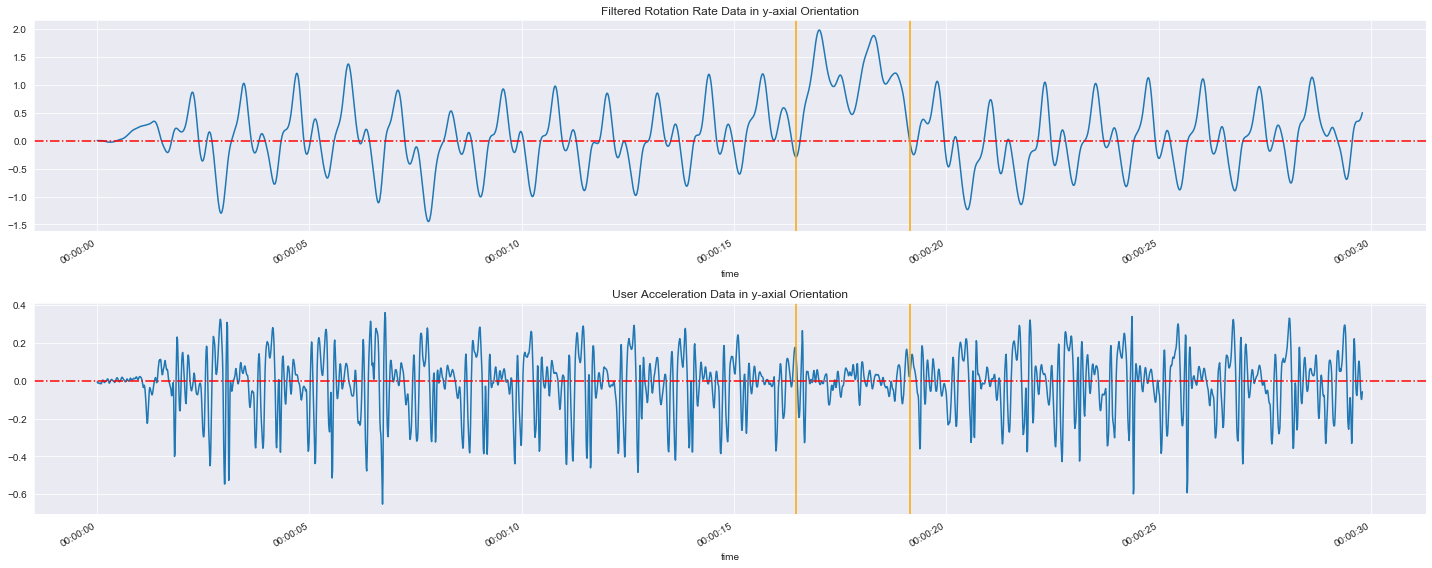

In [6]:
start = gaitFeaturize.compute_rotational_features(accel_data, rotation_data)[0]['rotation_window_start']
end = gaitFeaturize.compute_rotational_features(accel_data, rotation_data)[0]['rotation_window_end']
index_start = np.where(accel_data["td"] == start)
index_end = np.where(accel_data["td"] == end)


fig, axes = plt.subplots(2, 1)


rotation_data["y"].plot(grid = True, ax = axes[0], figsize = (20,8))
axes[0].set_title("Filtered Rotation Rate Data in y-axial Orientation")
axes[0].axhline(0, linestyle = "-.", color = "r")
axes[0].axvline(accel_data.iloc[index_start].index, color = "orange")
axes[0].axvline(accel_data.iloc[index_end].index, color = "orange")


accel_data["y"].plot(grid = True, ax = axes[1], figsize = (20,8))
axes[1].set_title("User Acceleration Data in y-axial Orientation")
axes[1].axhline(0, linestyle = "-.", color = "r")
axes[1].axvline(accel_data.iloc[index_start].index, color = "orange")
axes[1].axvline(accel_data.iloc[index_end].index, color = "orange")

fig.tight_layout()
fig.show()

In [7]:
## module for detecting rotation ##
pd.DataFrame(gaitFeaturize.rotation_feature_pipeline(filepath)).T

Sampling rate is 99.33333333333333 Hz
Sampling rate is 99.33333333333333 Hz


,0
rotation_auc,2.91569
rotation_aucXt,7.42123
rotation_avg_number_of_strides,2.5
rotation_avg_step_duration,0.5725
rotation_avg_stride_duration,1.2825
rotation_axis,y
rotation_cadence,1.96443
rotation_energy_freeze_index,3.07451
rotation_frequency_of_peaks,0
rotation_num_window,1


The implementation of the algorithm from the research paper (incorporated with other gait features during the rotation, will give you this following feature. Using the data dictionary and by plotting a vertical line on the detected rotation shows that there is a start of rotation at around 16th seconds to 19th seconds, which is consistent to our first hypothesis previously.

# 2. Segmenting Rest Motion (TODO)